In [9]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
# Set up transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Download and load training and test data
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Dataset details
print(f"Number of training images: {len(train_data)}")
print(f"Number of testing images: {len(test_data)}")
print(f"Image size: {train_data[0][0].shape}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.0MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 348kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.26MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.1MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Number of training images: 60000
Number of testing images: 10000
Image size: torch.Size([1, 28, 28])


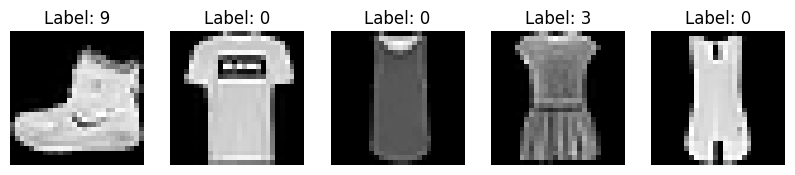

In [3]:
# Function to display sample images
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

# Show sample images
show_images(train_data)


In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # No activation here; it’ll be applied in the loss function
        return x

model = SimpleNN()
print(model)  # Display model architecture


SimpleNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)


In [5]:
# Hyperparameters
epochs = 5
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train(model, loader):
    model.train()  # Set model to training mode
    total_loss = 0
    for images, labels in loader:
        optimizer.zero_grad()  # Clear gradients
        output = model(images)  # Forward pass
        loss = criterion(output, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item()
    return total_loss / len(loader)

# Validation function
def validate(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total  # Return accuracy



In [6]:
for epoch in range(epochs):
    train_loss = train(model, train_loader)
    validation_accuracy = validate(model, test_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")


Epoch 1/5, Train Loss: 0.5198, Validation Accuracy: 0.8440
Epoch 2/5, Train Loss: 0.3783, Validation Accuracy: 0.8529
Epoch 3/5, Train Loss: 0.3407, Validation Accuracy: 0.8693
Epoch 4/5, Train Loss: 0.3154, Validation Accuracy: 0.8752
Epoch 5/5, Train Loss: 0.2926, Validation Accuracy: 0.8773


Performance Metrics on Test Data:
Accuracy: 0.8773
Precision: 0.8788
Recall: 0.8773
F1-Score: 0.8775
Confusion Matrix:


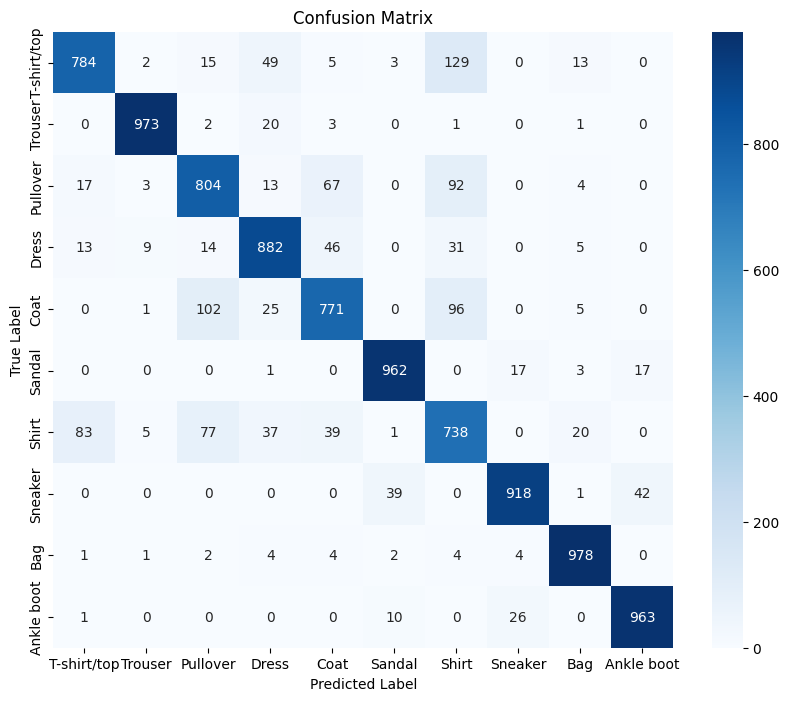

In [13]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]
def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in loader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print("Performance Metrics on Test Data:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Evaluate the model on test data
evaluate_model(model, test_loader)

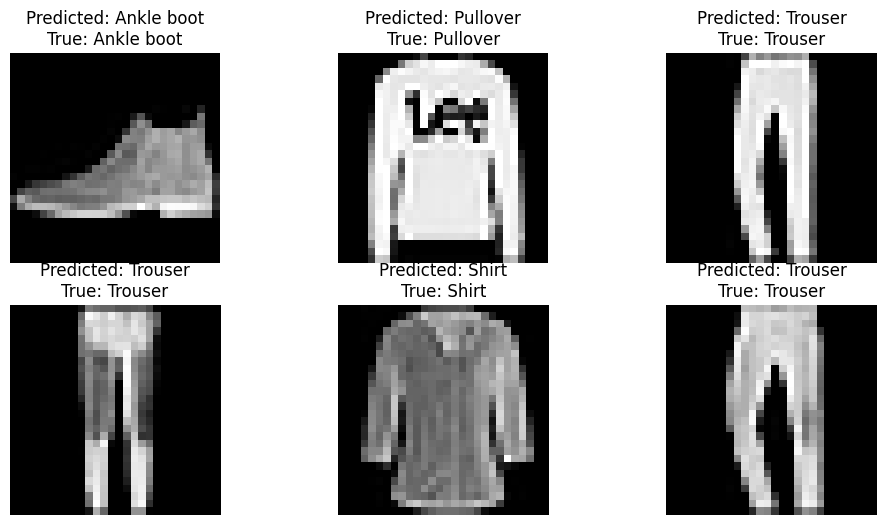

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display images along with predictions
def display_predictions(model, loader, class_names, num_images=6):
    # Get a batch of test data
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Run inference on the images
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Plot the images and predicted labels
    plt.figure(figsize=(12, 6))
    for idx in range(num_images):
        plt.subplot(2, 3, idx + 1)
        img = images[idx].squeeze().numpy()  # Remove channel dimension and convert to numpy
        plt.imshow(img, cmap="gray")
        plt.title(f"Predicted: {class_names[predicted[idx]]}\nTrue: {class_names[labels[idx]]}")
        plt.axis("off")
    plt.show()
display_predictions(model, test_loader, class_names, num_images=6)
